In [12]:
import tensorflow as tf
import numpy as np
import mdn
import matplotlib.pyplot as plt

Source: https://www.katnoria.com/mdn/ and https://github.com/cpmpercussion/keras-mdn-layer/blob/master/notebooks/MDN-2D-spiral-prediction.ipynb

Generate 2D inputs and outputs

In [ ]:
# Example presented in the PRML book
# Modified to be a 2D input/ output
def create_book_example(n=1000, cols=2):
    # sample uniformly over the interval (0,1)
    X = np.random.uniform(0., 1., (n,cols)).astype(np.float32)    
    # target values 
    y = X + 0.3 * np.sin(2 * np.pi * X) + np.random.uniform(-0.1, 0.1, size=(n,cols)).astype(np.float32)
    # test data
    x_test = np.linspace(0, 1, n).reshape(-1, cols).astype(np.float32)    
    return X, y, x_test



Define our neural network with 30 mixture density models

In [50]:
# In our toy example, we are using two inputs
l = 2
# Number of gaussians to represent the multimodal distribution (number of mixture density models), lets try 30
k = 30

# Network
input = tf.keras.Input(shape=(l,))
#I think this is a tuning parameter
layer = tf.keras.layers.Dense(50, activation='tanh', name='baselayer')(input)
# Connect the mdn layer to the output of our neural network
mdn_layer = mdn.MDN(l,k, name='mdn')(layer)

Build the model and display the summary

In [51]:
model = tf.keras.models.Model(input, [mdn_layer])
model.compile(loss=mdn.get_mixture_loss_func(l,k), optimizer=tf.keras.optimizers.Adam())
model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
baselayer (Dense)            (None, 50)                150       
_________________________________________________________________
mdn (MDN)                    (None, 150)               7650      
Total params: 7,800
Trainable params: 7,800
Non-trainable params: 0
_________________________________________________________________


Fit our model on the data with 300 iterations

In [52]:
X, y, x_test = create_book_example()

fit = model.fit(x=X, y=y, batch_size=128, epochs=300, validation_split=0.15, callbacks=[tf.keras.callbacks.TerminateOnNaN()])

Epoch 1/300
7/7 [==============================] - 2s 303ms/step - loss: 2.1276 - val_loss: 2.0165
Epoch 2/300
7/7 [==============================] - 0s 4ms/step - loss: 1.9917 - val_loss: 1.8764
Epoch 3/300
7/7 [==============================] - 0s 4ms/step - loss: 1.8414 - val_loss: 1.7142
Epoch 4/300
7/7 [==============================] - 0s 4ms/step - loss: 1.6638 - val_loss: 1.5200
Epoch 5/300
7/7 [==============================] - 0s 4ms/step - loss: 1.4479 - val_loss: 1.2912
Epoch 6/300
7/7 [==============================] - 0s 4ms/step - loss: 1.1972 - val_loss: 1.0386
Epoch 7/300
7/7 [==============================] - 0s 4ms/step - loss: 0.9248 - val_loss: 0.7834
Epoch 8/300
7/7 [==============================] - 0s 4ms/step - loss: 0.6433 - val_loss: 0.5032
Epoch 9/300
7/7 [==============================] - 0s 4ms/step - loss: 0.3347 - val_loss: 0.1825
Epoch 10/300
7/7 [==============================] - 0s 4ms/step - loss: 0.0179 - val_loss: -0.1099
Epoch 11/300
7/7 [========

Obtained a loss of -1.5942. The 1D example from medium had a loss of around -1.

In [ ]:
Plot the loss over the number of iterations

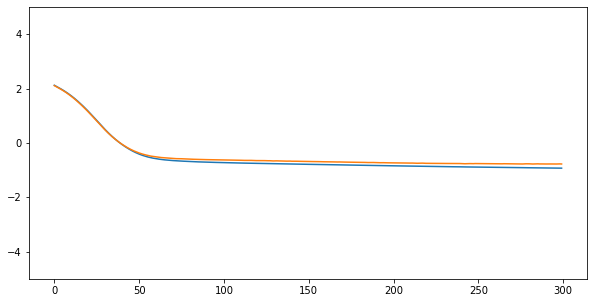

In [47]:
plt.figure(figsize=(10, 5))
plt.ylim([-5, 5])
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.show()

Get the predictions from our model by sampling the posterior distribution. Each mixture model produces a mean and sigma in each dimension for each test observation rather than a point estimate.

In [53]:
# Returns the predictions of the parameters of the distributions and weights
preds = model.predict(x_test)
y_samples = np.apply_along_axis(mdn.sample_from_output, 1, preds, l, k, temp=1.0, sigma_temp=1.0)

# Split up the mixture parameters (for future fun)
mus = np.apply_along_axis((lambda a: a[:k*l]), 1, preds)
sigs = np.apply_along_axis((lambda a: a[k*l:2*k*l]), 1, preds)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[-k:])), 1, preds)

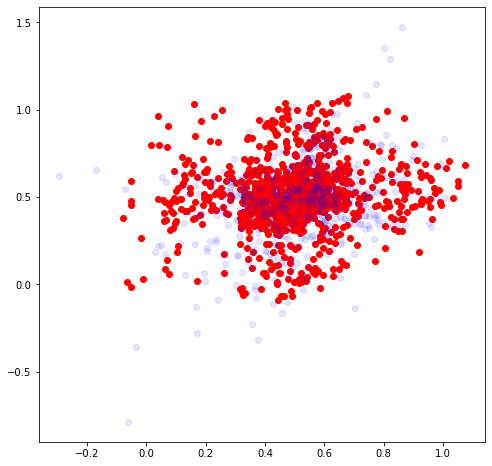

In [54]:
# Plot the predicted samples.
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.scatter(y[:,0], y[:,1], c='r')
ax.scatter(y_samples.T[0], y_samples.T[1], alpha=0.1, c='b')


This might be #badstats, but using the outputted means for each of our gaussian mixture density (30), take the weighted average of them to get point predictions in each dimension from our test Xs.

In [68]:
# Get weighted mu for each direction
y_mu_0 = np.sum(np.multiply(pis, mus[:,:k]),axis=1)
y_mu_1 = np.sum(np.multiply(pis, mus[:,k:]),axis=1)
display(np.array([y_mu_0, y_mu_1]).T)

array([[0.31752157, 0.22231655],
       [0.318875  , 0.2235617 ],
       [0.32022583, 0.22480191],
       [0.32157406, 0.22603686],
       [0.32291982, 0.22726676],
       [0.32426277, 0.22849147],
       [0.3256033 , 0.22971113],
       [0.32694107, 0.23092541],
       [0.32827643, 0.23213467],
       [0.3296092 , 0.23333858],
       [0.33093926, 0.23453729],
       [0.3322668 , 0.23573068],
       [0.33359188, 0.23691884],
       [0.33491424, 0.23810165],
       [0.33623415, 0.23927906],
       [0.33755133, 0.24045114],
       [0.3388661 , 0.24161795],
       [0.3401782 , 0.24277925],
       [0.34148797, 0.24393523],
       [0.34279504, 0.24508579],
       [0.34409955, 0.24623077],
       [0.34540156, 0.24737036],
       [0.346701  , 0.24850447],
       [0.3479979 , 0.24963312],
       [0.34929237, 0.25075614],
       [0.35058418, 0.25187373],
       [0.3518736 , 0.25298566],
       [0.35316047, 0.25409216],
       [0.35444474, 0.2551929 ],
       [0.3557265 , 0.2562881 ],
       [0.